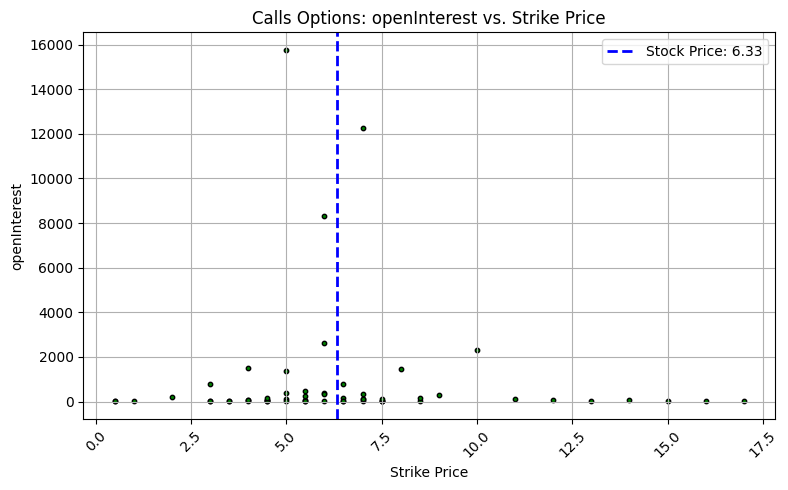

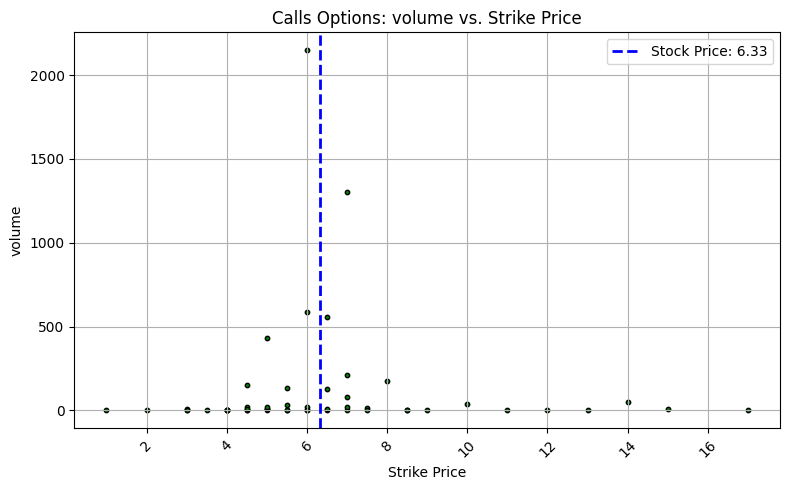

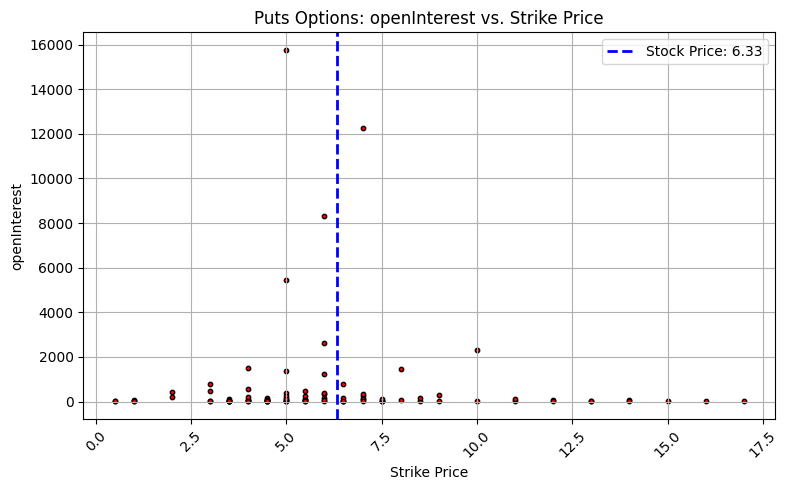

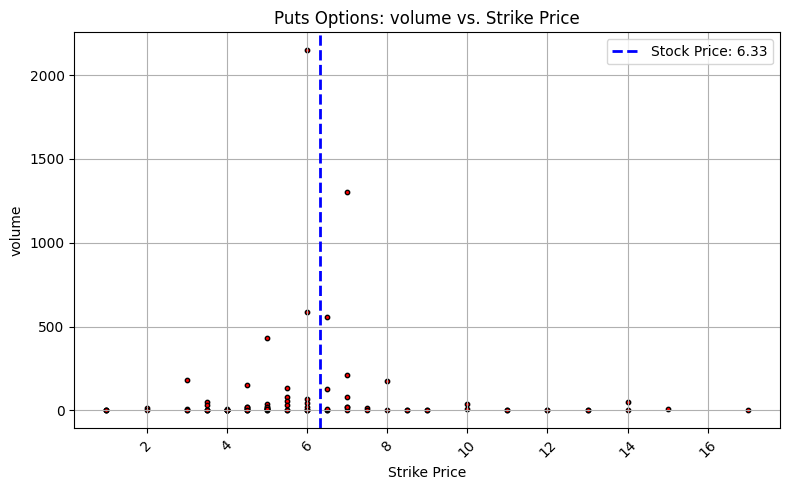

In [49]:
import setup
from imports import *
from scripts.scrape_url import get_stock_price

def options_chain(symbol):
    # Create a ticker object
    tk = yf.Ticker(symbol)
    # Get expiration dates
    exps = tk.options

    # Get the current date
    current_date = datetime.now().date()

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt_df = pd.concat([opt.calls, opt.puts])
        opt_df['expirationDate'] = e
        # Convert expirationDate to datetime.date for calculation
        opt_df['expirationDate'] = pd.to_datetime(opt_df['expirationDate']).dt.date
        # Calculate days to expiry
        opt_df['daysToExpiry'] = (opt_df['expirationDate'] - current_date).apply(lambda x: x.days)
        options = pd.concat([options, opt_df], ignore_index=True)

    # Filter out entries where daysToExpiry is greater than 30
    options = options[options['daysToExpiry'] <= 30]

    return options

def plot_option_data(df, option_type='Calls', y_axis='impliedVolatility', stock_price=None):
    # Filter based on option type
    df = df[df['contractSymbol'].str.contains('C' if option_type == 'Calls' else 'P')]
    # Remove entries with zero openInterest
    df = df[df['openInterest'] > 0]
    # Sort by strike price
    df = df.sort_values(by='strike', ascending=True)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(df['strike'], df[y_axis], 
                color='green' if option_type == 'Calls' else 'red', 
                edgecolors='black', s=10)
    plt.title(f'{option_type} Options: {y_axis} vs. Strike Price')
    plt.xlabel('Strike Price')
    plt.ylabel(y_axis)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # If stock price is provided, add a vertical line at that price
    if stock_price is not None:
        plt.axvline(x=stock_price, color='blue', linestyle='--', linewidth=2, label=f'Stock Price: {stock_price}')
    plt.legend()
    plt.show()

def plot_calls_puts_separately(df, ticker):

    stock_price = get_stock_price(ticker)

    plot_option_data(df, 'Calls', stock_price=stock_price, y_axis='openInterest')
    plot_option_data(df, 'Calls', stock_price=stock_price, y_axis='volume')

    plot_option_data(df, 'Puts', stock_price=stock_price, y_axis='openInterest')
    plot_option_data(df, 'Puts', stock_price=stock_price, y_axis='volume')

# Example usage:
ticker = 'APLD'
df = options_chain(ticker)
plot_calls_puts_separately(df, ticker)

